In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import torch
import math

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors import safe_open
from safetensors.torch import save_file
from timm.models.vision_transformer import VisionTransformer as timm_ViT
from torch import Tensor
from torch.nn.parameter import Parameter
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import kagglehub
from torchvision import datasets, transforms
from pathlib import Path
import torch   
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.optim as optim
from torchmetrics import Dice
import cv2
import time

In [2]:
!pwd

/kaggle/working


In [3]:
path = "/kaggle/input/lung-segment"

class LungSegmentationDataset(Dataset):
    def __init__(self, df=None, base_dir=None, resize=None, transform=None, target_transform=None, both_transform=None):
        self.data = df
        self.base_dir = Path(base_dir)
        self.resize = resize
        self.transform = transform
        self.target_transform = target_transform
        self.both_transform=both_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_relative_path = self.data.iloc[idx, 1]
        mask_relative_path = self.data.iloc[idx, 2]
        
        img_path = self.base_dir / img_relative_path
        mask_path = self.base_dir / mask_relative_path

        # Load image and mask using OpenCV
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        image = np.stack([image] * 3, axis=-1)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)


        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        #print(torch.unique(mask))
        mask = mask.long()
        return image, mask

#
#image = torch.from_numpy(image).permute(2,0,1).float()


df_data = pd.read_csv(path + "/train.csv")

train_df, val_df = train_test_split(df_data, test_size=0.2, random_state=42)

In [30]:
from torchvision.transforms import InterpolationMode

transform_toTensor = transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.uint8).unsqueeze(0))
#to_rgb = transforms.Lambda(lambda x: np.stack([x] * 3, axis=-1))



transform_train = transforms.Compose([
  #  to_rgb,
    transforms.ToTensor(),
    transforms.Resize((448, 448)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std = [0.1953, 0.1925, 0.1942]),
])
transform_train_mask = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32),interpolation=InterpolationMode.NEAREST_EXACT),
])


transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((448, 448)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std = [0.1953, 0.1925, 0.1942]),
])
transform_val_mask = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((448, 448), interpolation=InterpolationMode.NEAREST_EXACT),
])

In [31]:
#Training parameters
models = [] #Dino Frozen, DinoLora
rs =  [255, 0, 1, 3, 5, 10, 20] #255 being a dummy class for the full optimization no LORA
num_classes = 2
learning_rate = 1e-2
num_epochs = 10
batch_size=16
num_layers = 1
input_dim = 384*num_layers
learning_rate = 1e-2
weight_decay = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
train_dataset = LungSegmentationDataset(df=train_df, base_dir=path, resize=448, 
                                                    transform=transform_train, target_transform=transform_train_mask)

val_dataset = LungSegmentationDataset(df=val_df, base_dir=path, resize=448, 
                                      transform=transform_val, target_transform=transform_val_mask)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class LinearHead(nn.Module):
    def __init__(self, dino, r ,in_features=1920, out_features=101, bias=True):
        super(LinearHead, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if r == 0:
            for param in dino.parameters():
                param.requires_grad = False
            self.lora_dino = dino
        elif r == 255:
            self.lora_dino = dino
        else:
            self.lora_dino = LoRA_ViT(dino, r=r, alpha=15, num_classes=0)
        
    def forward(self, imgs, num_layers):
        feature = self.lora_dino.get_intermediate_layers(imgs, num_layers, return_class_token=True)
        outputs = []
        for patch_idx in range(feature[0][0].shape[1]):
            patch_features = torch.cat([feature[layer_idx][0][:, patch_idx, :] for layer_idx in range(num_layers)], dim=-1)
            patch_output = self.linear(patch_features)
            outputs.append(patch_output)
        
        outputs = torch.stack(outputs, dim=1)
        return outputs

In [6]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [10]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.losses import DiceLoss
metrics = smp.utils.metrics.IoU(eps=1.)

In [8]:

r = 0
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model = LinearHead(dinov2_vits14, r, input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda a : a.requires_grad, model.parameters()), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs*len(train_loader.dataset), eta_min=0.0001)
dice_metric = Dice(num_classes=2,ignore_index=0, threshold=0.5).to(device)


num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("trainable parameters", num_trainable_params)
iteration = {"r": r, "loss": [], "dice_metric": [], "trainable":num_trainable_params , "best_model": None, "time":None}

dice_metric_max = 0
start = time.time()

for epoch in range(num_epochs):
    total_train_batches = 0
    train_iou = 0
    print("Current Epoch: ", epoch)
    model.train()
    running_loss = 0.0
    for i, (imgs, patch_labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        patch_labels = patch_labels.to(device)
        
        outputs = model(imgs, num_layers)
        outputs = outputs.view(-1, num_classes)
        patch_labels = patch_labels.view(-1)
    
    
        loss = criterion(outputs, patch_labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # print(f"outputs shape: {outputs.shape}, patch_labels shape: {patch_labels.shape}")
        # iou_train = metrics(outputs, patch_labels)
        total_train_batches += 1
        # train_iou += iou_train.item()

    avg_train_iou = train_iou / total_train_batches
    
    model.eval()
    dice_metric.reset()
    val_loss = 0.0
    val_iou = 0.0
    total_val_batches = 0
    with torch.no_grad():
        for i, (imgs, mask) in enumerate(val_loader):
            imgs = imgs.to(device)
            mask = mask.to(device).squeeze(1)
            
            outputs = model(imgs, num_layers)

            outputs = outputs.view(-1, num_classes)

            trans = transforms.Resize((32, 32),interpolation=InterpolationMode.NEAREST_EXACT)
            
            loss_mask = trans(mask).view(-1)
            loss = criterion(outputs, loss_mask)
            val_loss += loss.item()
            # iou_val = metrics(outputs, loss_mask)
            # val_iou += iou_val.item()
            total_val_batches += 1

            preds = torch.argmax(outputs, dim=1)


            # preds = preds.view(-1, int(32), int(32))
            # resize = transforms.Resize(mask.shape[2], interpolation=transforms.InterpolationMode.NEAREST_EXACT)
            
            # preds = resize(preds)
            
            #patch_labels = patch_labels.view(-1, int(np.sqrt(feature[0][0].shape[1])), int(np.sqrt(feature[0][0].shape[1])))


            dice_metric.update(preds, mask)
        avg_val_iou = val_iou / total_val_batches
        avg_val_loss = val_loss / len(val_loader)
        dice_metric_avg = dice_metric.compute().item()
        print("Dice average for epoch: ",dice_metric_avg)
        print("Average Loss: ", avg_val_loss)
        print("train IoU: ", avg_train_iou)
        print("val IoU: ", avg_val_iou)
        if dice_metric_avg > dice_metric_max:
            dice_metric_max = dice_metric_avg
            torch.save(model.state_dict(), f"model_r{r}_LUNG.pth")
        iteration["loss"].append(avg_val_loss)
        iteration["dice_metric"].append(dice_metric_avg)
end = time.time()
length = end - start
iteration["time"] = length
iteration_df = pd.DataFrame([iteration])
df = pd.concat([df, iteration_df], ignore_index=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


trainable parameters 770
Current Epoch:  0


KeyboardInterrupt: 

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_30/99742123.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict

Output shape: torch.Size([1, 1024, 2])
Reshaped output shape: torch.Size([1, 32, 32, 2])
torch.Size([1, 32, 32])


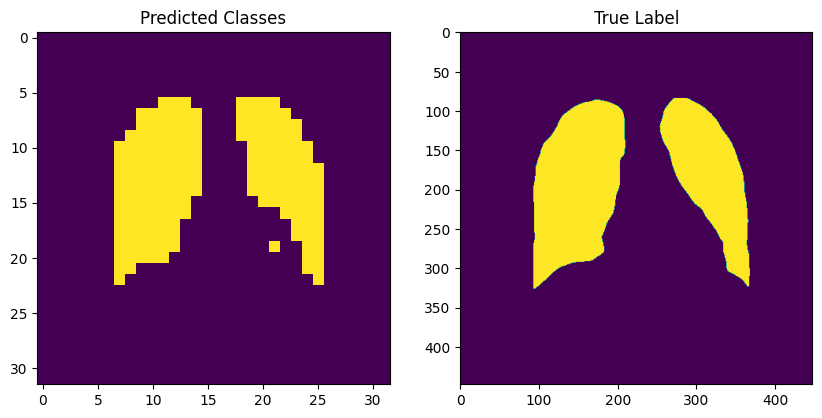

In [33]:
import torchvision.transforms as T
r = 0
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model = LinearHead(dinov2_vits14, r, input_dim, num_classes).to(device)
model.load_state_dict(torch.load("model_r0_LUNG.pth"))
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        first_image = images[0].unsqueeze(0).to(device)  # Take the first image and add batch dimension
        true_label = labels[0].cpu().numpy()  # Get the true label for the first image
        
        output = model(first_image, 1)
        print("Output shape:", output.shape)
        
        # Reshape the output to [1, 32, 32, 2]
        output_reshaped = output.view(1, 32, 32, 2)
        print("Reshaped output shape:", output_reshaped.shape)
        
        # Use argmax to get the class predictions
        predicted_classes = torch.argmax(output_reshaped, dim=-1)
        print(predicted_classes.shape)
        # Plot the class predictions
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(predicted_classes.cpu().squeeze())
        plt.title("Predicted Classes")
        
        plt.subplot(1, 2, 2)
        plt.imshow(true_label.squeeze())
        plt.title("True Label")
        
        plt.show()
        break  # Only process the first batch

torch.Size([16, 3, 448, 448])
1


In [38]:

import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

In [42]:
!pip install mmsegmentation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.5 MB/s eta 0:00:0000:01


In [45]:
!pip install mmcv-full

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.9/607.9 kB 16.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv-full: filename=mmcv_full-1.7.2-cp310-cp310-linux_x86_64.whl size=5888019 sha256=9c33cff9e7bad114861baf20e8144363b87b025e7a86fe4c45bf427cbe0740a4
  Stored in directory: /root/.cache/pip/wheels/4e/10/0a/78fbabe3d28cc25866432d4ecd6c9b124b8f0a6f546974bb7e
Successfully built mmcv-full


In [47]:
!pip install mmengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.3/452.3 kB 14.1 MB/s eta 0:00:00


In [4]:
!git clone https://github.com/facebookresearch/dinov2.git

Cloning into 'dinov2'...
remote: Enumerating objects: 485, done.
remote: Total 485 (delta 0), reused 0 (delta 0), pack-reused 485 (from 1)
Receiving objects: 100% (485/485), 1.11 MiB | 7.66 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [3]:
# import sys

# !{sys.executable} -m pip install -e dinov2'[extras]' \
#     --extra-index-url https://download.pytorch.org/whl/cu117 \
#     --extra-index-url https://pypi.nvidia.com



In [ ]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

In [2]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.transforms import InterpolationMode
import numpy as np
import torch
import math
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import datasets, transforms
from pathlib import Path
import torch   
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.optim as optim
from torchmetrics import Dice
import cv2
import time


True


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_31/3803008228.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

Output shape: torch.Size([1, 1024, 2])
Reshaped output shape: torch.Size([1, 32, 32, 2])
torch.Size([1, 32, 32])


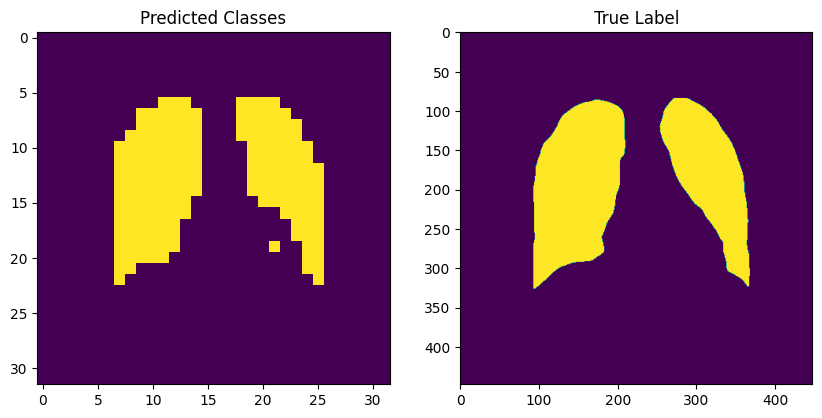

In [11]:
r = 0
num_classes = 2
learning_rate = 1e-4
num_epochs = 10
batch_size=16
num_layers = 1
input_dim = 384*num_layers
learning_rate = 1e-2
weight_decay = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = "/kaggle/input/lung-segment"

class LungSegmentationDataset(Dataset):
    def __init__(self, df=None, base_dir=None, resize=None, transform=None, target_transform=None, both_transform=None):
        self.data = df
        self.base_dir = Path(base_dir)
        self.resize = resize
        self.transform = transform
        self.target_transform = target_transform
        self.both_transform=both_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_relative_path = self.data.iloc[idx, 1]
        mask_relative_path = self.data.iloc[idx, 2]
        
        img_path = self.base_dir / img_relative_path
        mask_path = self.base_dir / mask_relative_path

        # Load image and mask using OpenCV
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        image = np.stack([image] * 3, axis=-1)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)


        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        #print(torch.unique(mask))
        mask = mask.long()
        return image, mask
    
transform_toTensor = transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.uint8).unsqueeze(0))
#to_rgb = transforms.Lambda(lambda x: np.stack([x] * 3, axis=-1))

transform_train = transforms.Compose([
  #  to_rgb,
    transforms.ToTensor(),
    transforms.Resize((448, 448)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std = [0.1953, 0.1925, 0.1942]),
])
transform_train_mask = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((448, 448),interpolation=InterpolationMode.NEAREST_EXACT),
])


transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((448, 448)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std = [0.1953, 0.1925, 0.1942]),
])
transform_val_mask = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((448, 448), interpolation=InterpolationMode.NEAREST_EXACT),
])

def load_dataset(path):
    df_data = pd.read_csv(path + "/train.csv")
    train_df, val_df = train_test_split(df_data, test_size=0.2, random_state=42)
    train_dataset = LungSegmentationDataset(df=train_df, base_dir=path, resize=448, 
                                                    transform=transform_train, target_transform=transform_train_mask)
    val_dataset = LungSegmentationDataset(df=val_df, base_dir=path, resize=448, 
                                        transform=transform_val, target_transform=transform_val_mask)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader
    

class LinearHead(nn.Module):
    def __init__(self, dino, r ,in_features=1920, out_features=101, bias=True):
        super(LinearHead, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if r == 0:
            for param in dino.parameters():
                param.requires_grad = False
            self.lora_dino = dino
        else:
            self.lora_dino = dino
        
    def forward(self, imgs, num_layers):
        feature = self.lora_dino.get_intermediate_layers(imgs, num_layers, return_class_token=True)
        outputs = []
        for patch_idx in range(feature[0][0].shape[1]):
            patch_features = torch.cat([feature[layer_idx][0][:, patch_idx, :] for layer_idx in range(num_layers)], dim=-1)
            patch_output = self.linear(patch_features)
            outputs.append(patch_output)
        outputs = torch.stack(outputs, dim=1)
        return outputs

def load_linear_model(model_path):
    dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
    model = LinearHead(dinov2_vits14, r, input_dim, num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    return model

def visualize_predictions(model, val_loader):
    with torch.no_grad():
        for images, labels in val_loader:
            first_image = images[0].unsqueeze(0).to(device)  # Take the first image and add batch dimension
            true_label = labels[0].cpu().numpy()  # Get the true label for the first image
            
            output = model(first_image, 1)
            print("Output shape:", output.shape)
            
            # Reshape the output to [1, 32, 32, 2]
            output_reshaped = output.view(1, 32, 32, 2)
            print("Reshaped output shape:", output_reshaped.shape)
            
            # Use argmax to get the class predictions
            predicted_classes = torch.argmax(output_reshaped, dim=-1)
            print(predicted_classes.shape)
            # Plot the class predictions
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.imshow(predicted_classes.cpu().squeeze())
            plt.title("Predicted Classes")
            
            plt.subplot(1, 2, 2)
            plt.imshow(true_label.squeeze())
            plt.title("True Label")
            
            plt.show()
            break  # Only process the first batch


def main():
    print(torch.cuda.is_available())
    train_loader, val_loader = load_dataset(path)
    model = load_linear_model("/kaggle/input/lung_small/pytorch/default/1/model_r0_LUNG.pth")
    visualize_predictions(model, val_loader)

main()

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(in_channels, 16)
        self.encoder2 = self.conv_block(16, 32)
        self.encoder3 = self.conv_block(32, 64)
        self.encoder4 = self.conv_block(64, 128)
        self.encoder5 = self.conv_block(128, 128)

        self.segmap_conv = nn.Conv2d(2, 128, kernel_size=1)

        self.bottleneck = self.conv_block(128, 256)

        self.upconv5 = self.upconv(256, 128)
        self.decoder5 = self.conv_block(256, 128)
        self.upconv4 = self.upconv(128, 128)
        self.decoder4 = self.conv_block(256, 128)
        self.upconv3 = self.upconv(128, 64)
        self.decoder3 = self.conv_block(128, 64)
        self.upconv2 = self.upconv(64, 32)
        self.decoder2 = self.conv_block(64, 32)
        self.upconv1 = self.upconv(32, 16)
        self.decoder1 = self.conv_block(32, 16)

        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x, small_segmap):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        enc5 = self.encoder5(F.max_pool2d(enc4, 2))

        if small_segmap is not None:
            # segmap should be (batch_size, 2, 32, 32)
            assert small_segmap.shape == (x.shape[0], 2, 32, 32)
            # cut the bounds of the segmentation map to be 28 by 28
            small_segmap = small_segmap[:, :, 2:30, 2:30]
            # pass the segmap into a 1x1 convolution to get the same number of channels as enc5
            small_segmap = F.relu(self.segmap_conv(small_segmap))
            # add the segmap to the bottleneck
            bottleneck = self.bottleneck(F.max_pool2d(enc5 + small_segmap, 2))
        else:
            bottleneck = self.bottleneck(F.max_pool2d(enc5, 2))

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5, enc5), dim=1)
        dec5 = self.decoder5(dec5)
        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)

In [13]:
small_segmap = torch.randn(1, 2, 32, 32)
model = UNet(in_channels=3, out_channels=2)
input_tensor = torch.randn(1, 3, 448, 448)
output = model(input_tensor, small_segmap)
print(output.shape)  # Should print torch.Size([1, 2, 448, 448])

torch.Size([1, 2, 448, 448])


In [26]:
def train_segmentation_upsampler(train_loader, val_loader, num_epochs):
    linear_model = load_linear_model("/kaggle/input/lung_small/pytorch/default/1/model_r0_LUNG.pth")
    model = UNet(in_channels=3, out_channels=2).to(device)
    learning_rate = 1e-4
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda a : a.requires_grad, model.parameters()), lr=learning_rate) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs*len(train_loader.dataset), eta_min=0.0001)
    dice_metric = Dice(num_classes=2,ignore_index=0, threshold=0.5).to(device)
    # params of linear model frozen
    for param in linear_model.parameters():
        param.requires_grad = False
    dice_metric_max = 0
    start = time.time()

    for epoch in range(num_epochs):
        total_train_batches = 0
        train_iou = 0
        print("Current Epoch: ", epoch)
        model.train()
        running_loss = 0.0
        for i, (imgs, patch_labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            patch_labels = patch_labels.to(device).squeeze(1)
            
            small_segmap = linear_model(imgs, num_layers)
            # small segmap should be (batch_size, 32, 32, 2)
            small_segmap = small_segmap.view(imgs.shape[0], 32, 32, 2).permute(0, 3, 1, 2)
            outputs = model(imgs, small_segmap)
            # print(f"outputs shape: {outputs.shape}, patch_labels shape: {patch_labels.shape}")
    
            loss = criterion(outputs, patch_labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # print(f"outputs shape: {outputs.shape}, patch_labels shape: {patch_labels.shape}")
            # iou_train = metrics(outputs, patch_labels)
            total_train_batches += 1
            # train_iou += iou_train.item()

        avg_train_iou = train_iou / total_train_batches
        
        model.eval()
        dice_metric.reset()
        val_loss = 0.0
        val_iou = 0.0
        total_val_batches = 0
        with torch.no_grad():
            for i, (imgs, mask) in enumerate(val_loader):
                imgs = imgs.to(device)
                mask = mask.to(device).squeeze(1)
                
                small_segmap = linear_model(imgs, num_layers)
                small_segmap = small_segmap.view(imgs.shape[0], 32, 32, 2).permute(0, 3, 1, 2)

                outputs = model(imgs, small_segmap)

                # print(f"Validation - imgs shape: {imgs.shape}, mask shape: {mask.shape}, small_segmap shape: {small_segmap.shape}, outputs shape: {outputs.shape}")

                trans = transforms.Resize((448, 448),interpolation=InterpolationMode.NEAREST_EXACT)
                
                loss_mask = trans(mask).view(-1)
                loss = criterion(outputs, mask)
                val_loss += loss.item()
                # iou_val = metrics(outputs, loss_mask)
                # val_iou += iou_val.item()
                total_val_batches += 1

                preds = torch.argmax(outputs, dim=1)


                # preds = preds.view(-1, int(32), int(32))
                # resize = transforms.Resize(mask.shape[2], interpolation=transforms.InterpolationMode.NEAREST_EXACT)
                
                # preds = resize(preds)
                
                #patch_labels = patch_labels.view(-1, int(np.sqrt(feature[0][0].shape[1])), int(np.sqrt(feature[0][0].shape[1])))


                dice_metric.update(preds, mask)
            avg_val_iou = val_iou / total_val_batches
            avg_val_loss = val_loss / len(val_loader)
            dice_metric_avg = dice_metric.compute().item()
            print("Dice average for epoch: ",dice_metric_avg)
            print("Average Loss: ", avg_val_loss)
            print("train IoU: ", avg_train_iou)
            print("val IoU: ", avg_val_iou)
            if dice_metric_avg > dice_metric_max:
                dice_metric_max = dice_metric_avg
                torch.save(model.state_dict(), f"model_r{r}_LUNG.pth")

In [27]:
train_loader, val_loader = load_dataset(path)
train_segmentation_upsampler(train_loader, val_loader, 20)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_31/3803008228.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

Current Epoch:  0
Dice average for epoch:  0.0
Average Loss:  0.5486898753378127
train IoU:  0.0
val IoU:  0.0
Current Epoch:  1
Dice average for epoch:  0.0
Average Loss:  0.33616125252511764
train IoU:  0.0
val IoU:  0.0
Current Epoch:  2
Dice average for epoch:  0.0
Average Loss:  0.29938071966171265
train IoU:  0.0
val IoU:  0.0
Current Epoch:  3
Dice average for epoch:  0.8917678594589233
Average Loss:  0.1568017370171017
train IoU:  0.0
val IoU:  0.0
Current Epoch:  4
Dice average for epoch:  0.9057795405387878
Average Loss:  0.12309976584381527
train IoU:  0.0
val IoU:  0.0
Current Epoch:  5
Dice average for epoch:  0.9115150570869446
Average Loss:  0.11391718768411213
train IoU:  0.0
val IoU:  0.0
Current Epoch:  6
Dice average for epoch:  0.912899911403656
Average Loss:  0.11596809493170844
train IoU:  0.0
val IoU:  0.0
Current Epoch:  7
Dice average for epoch:  0.9142608046531677
Average Loss:  0.10383289224571651
train IoU:  0.0
val IoU:  0.0
Current Epoch:  8
Dice average f